In [1]:
from zernike_algos import *
import numpy as np
import jax.numpy as jnp
import matplotlib
import matplotlib.pyplot as plt
import mpmath
import sys
import time
np.set_printoptions(threshold=sys.maxsize)

In [2]:
basis = ZernikePolynomial(L=50, M=50, spectral_indexing="ansi", sym="cos")
r = np.linspace(0, 1, 100)

radial = zernike_radial(r[:,np.newaxis], basis.modes[:,0], basis.modes[:,1], 0)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


0.2868525981903076


In [3]:
basis = ZernikePolynomial(L=50, M=50, spectral_indexing="ansi", sym="cos")
r = np.linspace(0, 1, 100)
l = basis.modes[:,0]
m = basis.modes[:,1]

jacobi_values = zernike_radial_optimized_jit(x=r, l=l, m=m)


6.2585530281066895


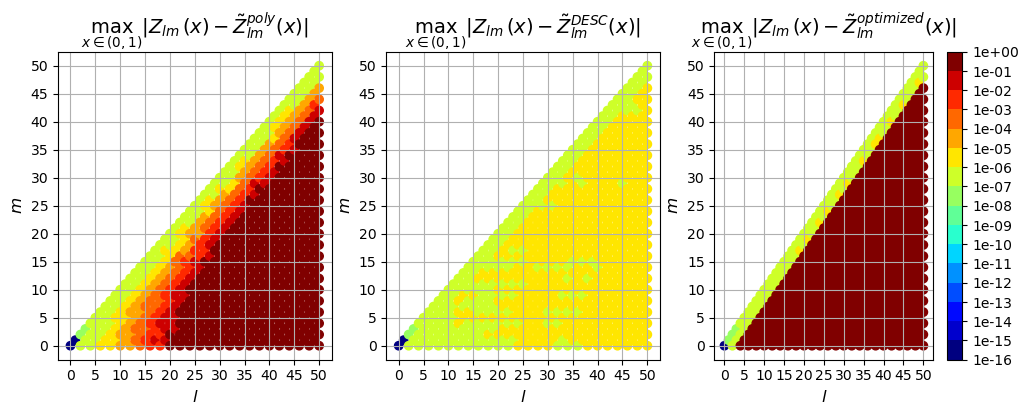

In [5]:
mpmath.mp.dps = 100
c = zernike_radial_coeffs(basis.modes[:, 0], basis.modes[:, 1], exact=True)

# current algorithm
zr0 = radial
# exact evaluation
zt0 = np.array([np.asarray(mpmath.polyval(list(ci), r), dtype=float) for ci in c]).T
# polynomial evaluation
zp0 = zernike_radial_poly(
    r[:, np.newaxis], basis.modes[:, 0], basis.modes[:, 1], dr=0, exact=False
)

cmap = plt.cm.jet  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]

# create the new map
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    "Custom cmap", cmaplist, cmap.N
)

# define the bins and normalize
bounds = np.logspace(-16, 0, 17)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
fig, ax = plt.subplots(1, 3, squeeze=True, figsize=(12, 4))
im = ax[0].scatter(
    basis.modes[:, 0],
    basis.modes[:, 1],
    c=np.max(abs(zp0 - zt0), axis=0),
    norm=norm,
    cmap=cmap,
)
im = ax[1].scatter(
    basis.modes[:, 0],
    basis.modes[:, 1],
    c=np.max(abs(zr0 - zt0), axis=0),
    norm=norm,
    cmap=cmap,
)
im = ax[2].scatter(
    basis.modes[:, 0],
    basis.modes[:, 1],
    c=np.max(abs(jacobi_values - zt0), axis=0),
    norm=norm,
    cmap=cmap,
)
cbar = fig.colorbar(im, ticks=bounds)
cbar.ax.set_yticklabels(["{:.0e}".format(foo) for foo in bounds])
ax[0].grid(True)
ax[1].grid(True)
ax[2].grid(True)
ax[0].set_xticks(np.arange(0, 55, 5))
ax[0].set_yticks(np.arange(0, 55, 5))
ax[1].set_xticks(np.arange(0, 55, 5))
ax[1].set_yticks(np.arange(0, 55, 5))
ax[2].set_xticks(np.arange(0, 55, 5))
ax[2].set_yticks(np.arange(0, 55, 5))
ax[0].set_xlabel("$l$", fontsize=12)
ax[0].set_ylabel("$m$", fontsize=12)
ax[1].set_xlabel("$l$", fontsize=12)
ax[1].set_ylabel("$m$", fontsize=12)
ax[2].set_xlabel("$l$", fontsize=12)
ax[2].set_ylabel("$m$", fontsize=12)
ax[0].set_title(
    "$\max_{x \in (0,1)} |Z_{lm}(x) - \\tilde{Z}_{lm}^{poly}(x)|$", fontsize=14
)
ax[1].set_title(
    "$\max_{x \in (0,1)} |Z_{lm}(x) - \\tilde{Z}_{lm}^{DESC}(x)|$", fontsize=14
);
ax[2].set_title(
    "$\max_{x \in (0,1)} |Z_{lm}(x) - \\tilde{Z}_{lm}^{optimized}(x)|$", fontsize=14
);

In [6]:
print("zernike_radial, 0th derivative")
%timeit _ = zernike_radial(r[:,np.newaxis], basis.modes[:,0], basis.modes[:,1], 0).block_until_ready()

zernike_radial, 0th derivative
1.41 ms ± 8.31 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
